In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from random import shuffle
from sklearn.utils import shuffle
import itertools
import matplotlib.pyplot as plt
import csv
import time

def Sigmoid(Z):
    return 1/(1+np.exp(-Z))

def Relu(Z):
    return np.maximum(0,Z)
    
def forward(X,Y, w1, w2, w3,ch):    
    Z1 = w1.dot(X.transpose()) 
    A1 = Sigmoid(Z1)
    ch['Z1'], ch['A1'] = Z1, A1
        
    Z2 = w2.dot(A1) 
    A2 = Sigmoid(Z2)
    ch['Z2'], ch['A2'] = Z2, A2
        
    Z3 = w3.dot(A2) 
    A3 = Sigmoid(Z3)
    ch['Z3'], ch['A3'] = Z3, A3
        
    Yh = A3
    loss = nloss(A3,Y)
    
    return Yh, loss, ch
    
def nloss(Yh,Y):
    loss = (1./len(Y)) * (-np.dot(Y,np.log(Yh).T) - np.dot(1-Y, np.log(1-Yh).T))    
    return loss
    
def predict(Y,Yh):
    acc = 0
    for i in range(0, len(Y)):
        if Yh[0][i] > 0.5:
            y = 1
        else:
            y = 0
        if (Y[i]==y):
            acc+= 1
    return acc/len(Y)
    
def dRelu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def dSigmoid(Z):
    s = 1/(1+np.exp(-Z))
    dZ = s * (1-s)
    return dZ
    
def backward(Y,Yh,X, w1, w2, w3,lr, ch):
    dLoss_Yh = -(np.divide(Y, Yh) - np.divide(1- Y, 1- Yh))
    dLoss_Z3 = dLoss_Yh * dSigmoid(ch['Z3'])
    dLoss_A2 = np.dot(w3.T, dLoss_Z3)
    dLoss_W3 = 1./ch['A2'].shape[1] * np.dot(dLoss_Z3,ch['A2'].T)
        
    dLoss_Z2 = dLoss_A2 * dSigmoid(ch['Z2'])
    dLoss_A1 = np.dot(w2.T, dLoss_Z2)
    dLoss_W2 = 1./ch['A1'].shape[1] * np.dot(dLoss_Z2,ch['A1'].T)
                            
    dLoss_Z1 = dLoss_A1 * dSigmoid(ch['Z1']) 
    dLoss_A0 = np.dot(w1.T,dLoss_Z1)
    dLoss_W1 = 1./X.shape[1] * np.dot(dLoss_Z1,X)
        
        
    w1 = w1 - lr * dLoss_W1
    w2 = w2 - lr * dLoss_W2
    w3 = w3 - lr * dLoss_W3
    return w1,w2,w3
if __name__ == "__main__": 
    startTime = time.time()        
    df = pd.read_csv("BIG_DWH_Training.csv", sep=',',names=["index", "Height", "weight", "gender"])
    femaleSet = df.loc[df['gender'] == -1]
    maleSet = df.loc[df['gender'] == 1]
    df = shuffle(df)
    final_val = []
    final_weights = []
    ch = {}
    dims = [2,5,5,1]
    param = {}
    costs = []
    avgLoss = 0
    avgacc = 0
    all_val_loss = []
    trainAcc =[]
    valAcc =[]
    count = 0 
    weights = []
    Yh=np.zeros((1,50))
    scaler = preprocessing.StandardScaler().fit(df.iloc[:, 1:3].values)
    Xtrain = scaler.transform(df.iloc[:, 1:3].values)
    df['Height'] = Xtrain[:, 0]
    df['weight'] = Xtrain[:, 1]
    train_len = int(len(df) * .95)
    test_len = int(len(df) * .05)
    train = df[0:train_len]
    test = df[train_len:train_len + test_len]

    np.random.seed(1)
    param['W1'] = np.random.randn(dims[1], dims[0])*np.sqrt(2/dims[0])
    param['W2'] = np.random.randn(dims[2], dims[1])*np.sqrt(2/dims[1])
    param['W3'] = np.random.randn(dims[3], dims[2])*np.sqrt(2/dims[2])
    print("Learning Rate :",5,"/t")
    
    for itr in range(1, 3000):
        lr = 5/itr
        train = shuffle(train)
        train_batch = train[0:50]
        train_X = train_batch.iloc[:, 1:3].values
        train_y = train_batch.iloc[:,3].values
        Yh, loss, ch = forward(train_X,train_y,param['W1'],param['W2'],param['W3'],ch)
        param['W1'],param['W2'],param['W3'] = backward(train_y, Yh,train_X, param['W1'],param['W2'],param['W3'],lr, ch)
        acc = predict(train_y,Yh)
        avgLoss = avgLoss + loss
        avgacc = avgacc + acc

        if ((itr % 250 == 0) and (count !=5)):
            print("**********************************************")
            print ("Cost after iteration %i: %f" %(itr, avgLoss/itr))
            print ("Training Accuracy :",(avgacc*100)/itr)
            costs.append(avgLoss/itr)
            trainAcc.append((avgacc*100)/itr)
            val = shuffle(test)
            val_batch = test[0:50]
            val_X = val_batch.iloc[:, 1:3].values
            val_y = val_batch.iloc[:,3].values
            val_Yh, val_loss, ch = forward(val_X,val_y,param['W1'],param['W2'],param['W3'],ch)
            all_val_loss.append(val_loss)
            weights.append(param)
            val_acc = predict(val_y,val_Yh)
            valAcc.append(val_acc*100)
            if(len(all_val_loss)>=5):    
                for i in range(2,6):
                    if(all_val_loss[-1]> all_val_loss[-i]):
                        count+=1

            print("Validation Loss :",val_loss[0] )
            print("Validation Accuracy :",val_acc*100 )
            #print("**********************************************")
        elif ((itr % 250 == 0) and (count == 5)):
            final_val.append(val_loss)
            final_weights.append(weights[-2])
            print("Final weights :", final_weights)
            print("final_val :",final_val)
            print("Early Stoping")
            break
        elif(itr == 2999):
            final_val.append(val_loss)
            final_weights.append(weights[-2])
            #print("Final weights :", final_weights)
            print("final_val :",final_val)
    tmp = min(final_val)
    index =final_val.index(tmp)
    print("Final weight for good learning rate :",final_weights[index])
    endTime = time.time()  
    avgtime = (endTime - startTime)/100
    print("Average Time taken = ", avgtime)  

Learning Rate : 5 /t
**********************************************
Cost after iteration 250: 0.315150
Training Accuracy : 92.7199999999999
Validation Loss : 0.21893729073065907
Validation Accuracy : 94.0
**********************************************
Cost after iteration 500: 0.287137
Training Accuracy : 93.05599999999984
Validation Loss : 0.19875277866364843
Validation Accuracy : 94.0
**********************************************
Cost after iteration 750: 0.273767
Training Accuracy : 93.13333333333345
Validation Loss : 0.1896291658314125
Validation Accuracy : 94.0
**********************************************
Cost after iteration 1000: 0.268359
Training Accuracy : 93.00400000000042
Validation Loss : 0.18441969012513432
Validation Accuracy : 94.0
**********************************************
Cost after iteration 1250: 0.262898
Training Accuracy : 93.03200000000109
Validation Loss : 0.18048525970668955
Validation Accuracy : 94.0
**********************************************
Cost af

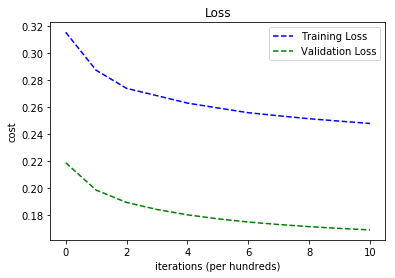

In [7]:
plt.plot(costs, 'b--')
plt.plot(all_val_loss, 'g--')
plt.legend(['Training Loss', 'Validation Loss'])
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title('Loss')
plt.show()

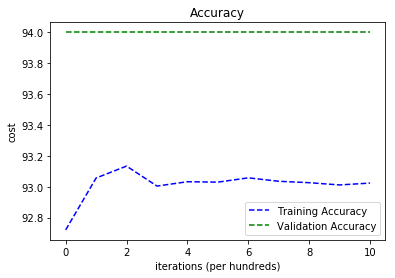

In [8]:
plt.plot(trainAcc, 'b--')
plt.plot(valAcc, 'g--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title('Accuracy')
plt.show()